<a href="https://colab.research.google.com/github/tmathema/Candidate-hire-classification-interpretability/blob/main/Intepretability_candidate_hire_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#uploading the datasets
candidates = pd.read_csv('/content/gdrive/MyDrive/absa_assessment/candidates.csv')
admissions = pd.read_csv('/content/gdrive/MyDrive/absa_assessment/admissions.csv')

In [ ]:
#average age of candidates
print(candidates.age.mean())

43173.60390471217


<AxesSubplot:>

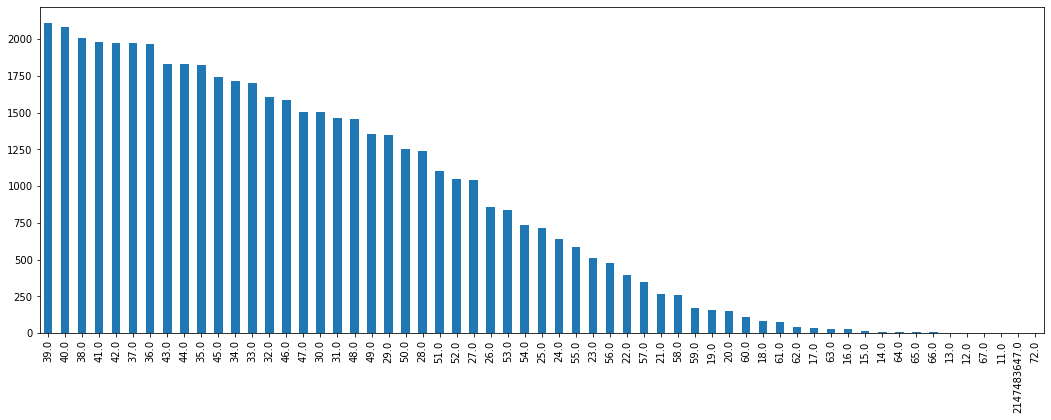

In [ ]:
#bar plot showing the data distribution of the participants' age
candidates.age.value_counts().plot(kind = 'bar', figsize=(18, 6))

**Assumptions:**
The basic minimum age for employment is 16, and age of retirement is generally between 60 and 65 years, however, an employee cannot be forced to retire unless their employment contract specifies the retirement age or there is a company policy that sets the official age for retirement. Therefore, data was filtered based on ages between, 16 and 100, to exclude the participants below the minimum prescribed age of recruitment and outliers.

In [ ]:
#filtering the data based on age.
candidates = candidates[candidates.age.between(16,100, inclusive = True)]

Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


<AxesSubplot:>

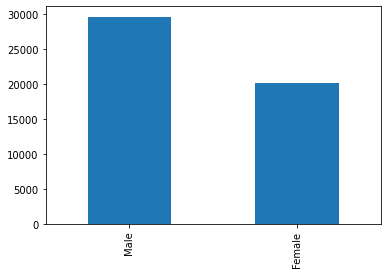

In [ ]:
#bar plot showing the data distribution of the gender of participants
candidates.gender.value_counts().plot(kind = 'bar')

<AxesSubplot:>

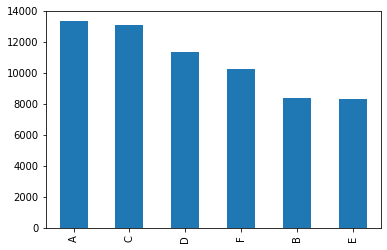

In [ ]:
#data distribution of departments
admissions.department.value_counts().plot(kind = 'bar')

In [ ]:
# merging the data set based on candidate id
data = pd.merge(candidates, admissions, how="inner", on='candidate_id')

In [ ]:
data.head(2)

,name,candidate_id,age,gender,no_children,emp_card_id,department,admit
0,Geneva Le,928100,43.0,Female,NaN,7505.0,D,Admitted
1,Marilyn Weber,913797,51.0,Male,0.0,NaN,C,Admitted


In [ ]:
#checking for missing data
data.isna().sum()

name                0
candidate_id        0
age                 0
gender              0
no_children      9552
emp_card_id     42084
department          0
admit               0
dtype: int64

# Data preprocessing

In [ ]:
#re-encoding of the categorical variables: gender, departments and admit
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

data['gender'] = label_encoder.fit_transform(data['gender'])
data['department'] = label_encoder.fit_transform(data['department'])
data['admit'] = label_encoder.fit_transform(data['admit'])

In [ ]:
#standardisation of the variables age and number of children
from sklearn.preprocessing import StandardScaler
# standardization
data[['age', 'no_children']] = StandardScaler().fit_transform(data[['age', 'no_children']])

In [ ]:
#undersampling the dataset to make it balanced
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
from sklearn.model_selection import train_test_split
from collections import Counter
X_data_balanced, y_data_balanced = under_sampler.fit_resample(data[['age', 'gender', 'no_children', 'department']], data['admit'])
print(f"Training target statistics: {Counter(X_data_balanced)}")
print(f"Training target statistics: {Counter(y_data_balanced)}")

Training target statistics: Counter({'age': 1, 'gender': 1, 'no_children': 1, 'department': 1})
Training target statistics: Counter({0: 25037, 1: 25037})


In [ ]:
#splitting the dataset into train and test sets
X_train, X_test = train_test_split(X_data_balanced, test_size=0.2, random_state =123)
y_train, y_test = train_test_split(y_data_balanced, test_size=0.2, random_state =123)

Model Selection:
Assessed 2 base models: XGBoost and Support vector models.
The model with the highest accuracy was be chosen.




In [ ]:
## XGBoost
import xgboost
from numpy import mean
from numpy import std
xgb_model = xgboost.XGBClassifier()
from sklearn.model_selection import cross_val_score
score=cross_val_score(xgb_model,X_train,y_train,cv=10)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(score), std(score)))

Accuracy: 0.901 (0.005)


In [ ]:
#we will need to exclude nan's to fit the svm model
data_svm = data[['age', 'gender', 'no_children', 'department', 'admit']].dropna()

In [ ]:
#undersampling the dataset to make it balanced
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
from sklearn.model_selection import train_test_split
from collections import Counter
X_data_balanced_svm, y_data_balanced_svm = under_sampler.fit_resample(data_svm[['age', 'gender', 'no_children', 'department']],
                                                                      data_svm['admit'])
print(f"Training target statistics: {Counter(X_data_balanced)}")
print(f"Training target statistics: {Counter(y_data_balanced)}")

Training target statistics: Counter({'age': 1, 'gender': 1, 'no_children': 1, 'department': 1})
Training target statistics: Counter({0: 25037, 1: 25037})


In [ ]:
#splitting the dataset into train and test sets
X_train_svm, X_test_svm = train_test_split(X_data_balanced_svm, test_size=0.2, random_state =123)
y_train_svm, y_test_svm = train_test_split(y_data_balanced_svm, test_size=0.2, random_state =123)

In [ ]:
# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC
svm_model = SVC(kernel = 'linear', random_state = 0)
svm_model.fit(X_train_svm, y_train_svm)
# Predicting the Test set results
y_pred = svm_model.predict(X_test_svm)
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test_svm,y_pred)
accuracy

0.880349344978166

#Model training

The XGBoost model has the highest accuracy, hence will be choosen for evaluation.

In [ ]:
## Hyper Parameter Optimization to choose the model with the best parameters
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.3, 0.4],
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]

}

In [ ]:
# Hyper parameter tuning using random search
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
random_search=RandomizedSearchCV(xgb_model,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,
                                 verbose=3, random_state = 1)

In [ ]:
#random serch for the best hyper parameters.
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=100, n_jobs=None,
                     

In [ ]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# hyperparameters ascertained by the random search
random_search.best_params_

{'min_child_weight': 7,
 'max_depth': 6,
 'learning_rate': 0.4,
 'gamma': 0.2,
 'colsample_bytree': 0.5}

In [ ]:
#initialising the model
classifier=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.2, learning_rate=0.4,
       max_delta_step=0, max_depth=6, min_child_weight=7, missing=1,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, verbosity=0)

In [ ]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(classifier,X_train,y_train,cv=10)
score

array([0.89715427, 0.89241138, 0.89790315, 0.89965052, 0.90314528,
       0.89715427, 0.90289566, 0.8994009 , 0.90763854, 0.91210986])

In [ ]:
from numpy import mean
from numpy import std
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(score), std(score)))

Accuracy: 0.901 (0.005)


In [ ]:
# Creating some predictions.
from sklearn.model_selection import cross_val_predict
y_test_pred = cross_val_predict(classifier, X_test, y_test, cv=5)

# Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)


array([[4444,  483],
       [ 503, 4585]])

In [ ]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))

0.9046961325966851
0.9011399371069182


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

XG-Boost model: ROC AUC=0.971


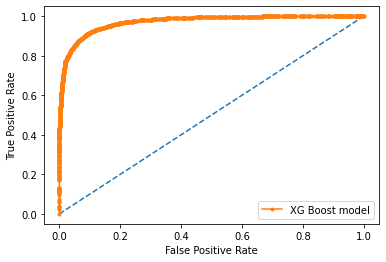

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
classifier.fit(X_test, y_test)
# predict probabilities
lr_probs = classifier.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XG-Boost model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='XG Boost model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# Applying Grid Search to find the best model and the best parameters: it took a long time to run, hence not implemented
#from sklearn.model_selection import GridSearchCV
#grid_search = GridSearchCV(estimator = classifier,
#                           param_grid = params,
#                           scoring = 'accuracy',
#                           cv = 10,
#                           n_jobs = -1)
#grid_search = grid_search.fit(X_train, y_train)
#accuracy = grid_search.best_score_
#grid_search.best_params_

# Interpretability:
Used the SHapley Additive exPlanations(SHAP) methodology for interpretation.
https://github.com/shankarpandala/lazypredict.

The SHAP methodology shows the contribution or the importance of each feature on the prediction of the model.

In [ ]:
!pip install shap

In [ ]:
import shap
# Fit the model on the data
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=6, max_leaves=None, min_child_weight=7, missing=1,
              monotone_constraints=None, n_estimators=100, n_jobs=1,
              nthread=None, num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Fits the explainer
explainer = shap.Explainer(classifier.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Exact explainer: 10016it [02:07, 72.11it/s]                            


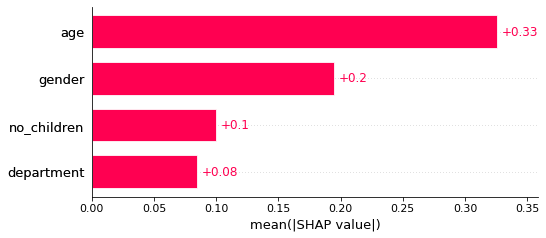

In [ ]:
#variable importance plot
shap.plots.bar(shap_values)

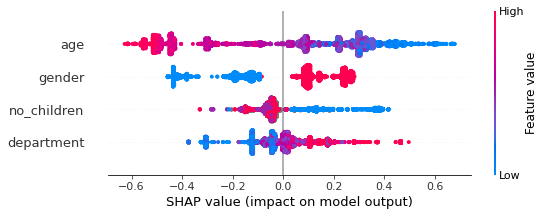

In [ ]:
#interaction of features and SHAP values
#On the beeswarm the features are also ordered by their effect on prediction,
#but we can also see how higher and lower values of the feature will affect the result.
#the beeswarm plot
shap.summary_plot(shap_values)

From the Beeswarn plot above, there is a clear separation between lower  and upper gender values' contribution to the predictions. The lower values contributed to the lower values of SHAP and higher values contributed to higher values of SHAP. This signifies a possibility of discrimination against a certain gender.

The next plots will show how features influenced a single prediction. For example participant 0 and 1, who were females and participant 3 and 4 who was male.

In [ ]:
X_test.head()

,age,gender,no_children,department
45970,-1.273891,0,-1.189543,2
32802,-1.498754,0,-1.189543,3
7259,-0.374437,0,NaN,4
36469,0.075290,1,NaN,3
2803,1.649334,1,2.200214,0


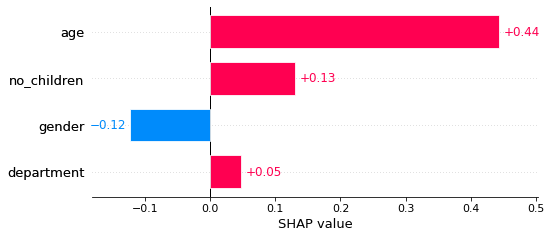

In [ ]:
#This plot shows us what are the main features affecting the prediction of a single observation,
# and the magnitude of the SHAP value for each feature.
#This is the first participant
shap.plots.bar(shap_values[0])

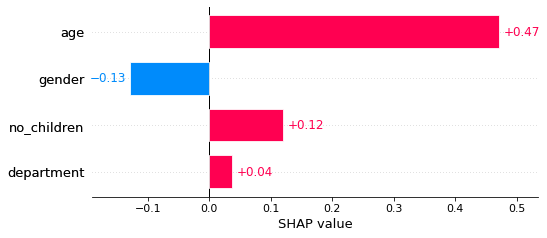

In [ ]:
shap.plots.bar(shap_values[1])

The 2 plots above, show that the gender variable had a negative influence on the overrall prediction of the 2 candidates.

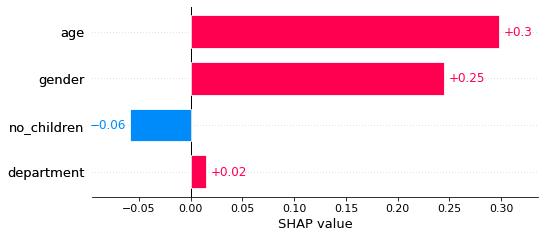

In [ ]:
shap.plots.bar(shap_values[3])

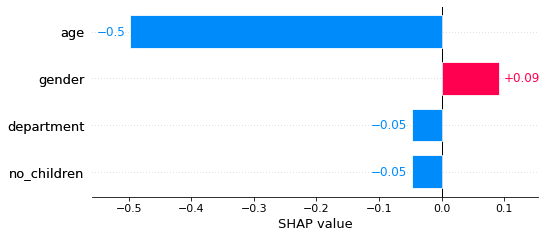

In [ ]:
shap.plots.bar(shap_values[4])

On the 2 plots above, we can note that the gender feature didnot negatively influence the prediction. Thereby proving the discrimination.